## Problem 1 - Transient Conduction in a Plane Wall

The problem we consider is that of a plane wall initially at 100$^\circ$C with its outer surfaces exposed to an ambient temperature of 0$^\circ$C.  The wall has a thickness 2*L* and may be considered to have an infinite height and a unit depth. The domain is shown schematically below:

![PlaneWall](Figures/2-PlaneWall.png)

Initially, the wall only feels the effect of the ambient air very near the surface and thus, the temperature profile inside the solid is quite steep in the vicinity of the surface.  An analytical solution for this problem involves several (at least 4) terms of a Fourier series.  After some time, however, the influence of the ambient air will have reached the center of the wall and the analytical solution can be approximated by the first term of the Fourier series (see, for example, *Fundamentals of Heat and Mass Transfer* by Incropera et al.). To study the order of accuracy of the fully implicit first and second order time discretization schemes, we will consider the cooling process during a period past the initial transient where the one-term Fourier solution is valid.

The parameters for the problem are:

$$ Bi = \frac{h L}{k}= 1.0 $$

$$ T_i = 100^\circ C $$

$$ T_{\infty}= 0^\circ C $$

The one-term Fourier solution for this problem is:

$$
\frac{T-T_{\infty}}{T_i-T_{\infty}}=C_1 \exp\left(-\zeta^2\frac{\alpha t}{L^2}\right)\cos\left(\zeta \frac{x}{L}\right)
$$

where:

$$ T = T(x,t) $$

$$ \alpha = \frac{k}{\rho c_p} $$

$$ C_1 = 1.1191 $$

$$ \zeta = 0.8603 $$

The solution to this problem at the two different dimensionless time levels of interest is:

$$ \text{at } \frac{\alpha t_1}{L^2}= 0.4535,~~~ T(0,t_1)= 80^\circ C $$

$$ \text{at } \frac{\alpha t_2}{L^2}= 3.2632,~~~ T(0,t_2)= 10^\circ C $$

To solve this problem, initialize the temperature field using the analytical solution at $\alpha t_1/L^2 = 0.4535$. This avoids the need for a very small timestep during the initial transient when solution is changing rapidly. Then, use your code to calculate the temporal variation of the temperature field over the time period described above.  Solve the problem by employing 2, 4, 8, 16, and 32 time steps using both the first and second order implicit schemes.

At the end of each run, calculate the absolute average error, $\overline{e}$, using the formula:

$$
\overline{e}= \frac{1}{N_{CV}} \sum_{i=1}^{N_{CV}} |e(i)|
$$

where

$$ e(i) = T_{exact}(i) - T(i) $$ 

Then, for each scheme, plot your results of $\overline{e}$ vs. $\Delta t$ (on a log-log scale) and find the value of $p$ in the expression:

$$
\overline{e}= c (\Delta t)^p
$$

where $p$ represents the order accuracy of the transient scheme. Also show a separate plot of T(0,$t_2$) verses the number of timesteps used for each scheme employed.

Repeat this problem on at least three different grids to demonstrate grid independence of the solution.

**Bonus**: Solve the same problem using the Crank-Nicolson scheme and compare the results.



# SOLUTION

In [382]:
class RobinBc:
    """Class defining a Robinn boundary condition"""
   
    def __init__(self, phi, grid, h, k, To, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._To = To
        self._loc = loc
       
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
   
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
     
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
            

In [383]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        trans = (self._rho*self._cp*self._grid.vol)*((self._T[1:-1] - self._Told[1:-1])/self._dt)
        
        # Calculate the linearization coefficient
        
        coeffPt = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        
        coeffs.accumulate_aP(coeffPt)
        coeffs.accumulate_rP(trans)

        return coeffs

In [384]:
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs, tStep):
        """Function to add transient term to coefficient arrays"""

        if tStep == 0:
            
            #Calculate the transient term
            trans = (self._rho*self._cp*self._grid.vol)*((self._T[1:-1] - self._Told[1:-1])/self._dt)
            
            #Calculate the linearization coefficient
            coeffPt = (self._rho*self._cp*self._grid.vol)/self._dt
        else:
            
            #Calculate the transient term
            trans = (self._rho*self._cp*self._grid.vol)*(((3*self._T[1:-1]/2) - (2*self._Told[1:-1]) + (self._Told2 [1:-1]/2))/self._dt)
            
            #Calculate the linearization coefficient
            coeffPt = (3*self._rho*self._cp*self._grid.vol)/(2*self._dt)
                  
        # Add to coefficient arrays
        
        coeffs.accumulate_aP(coeffPt)
        coeffs.accumulate_rP(trans)

        return coeffs

## Grid Independence Test

This grid independence test is being done on the solution of the problem using the first order implicit method for the transient term

### Number of control values : 10

In [385]:
import math
import numpy as np
from numpy.linalg import norm
import math

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve


# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
print(T_solns[-1])

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.059119562198017665; Avg. Resid. = 0.05213114913902881
Iteration = 1; Max. Resid. = 1.1587952819525071e-15; Avg. Resid. = 5.467848396278896e-16
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.055509653742855394; Avg. Resid. = 0.048956586164236426
Iteration = 1; Max. Resid. = 1.2836953722228372e-15; Avg. Resid. = 6.203371150093063e-16
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.052119709866059336; Avg. Resid. = 0.045973223694712115
Iteration = 1; Max. Resid. = 7.077671781985373e-16; Avg. Resid. = 4.905797990062411e-16
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.048938314698558825; Avg. Resid. = 0.043171072167754225
Iteration = 1; Max. Resid. = 1.0547118733938987e-15; Avg. Resid. = 4.662936703425658e-16
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.045952586216623105; Avg. Resid. = 0.0405394848739567
Iteration = 1; Max. Resid. =

### For a number of control volumes = 40

In [386]:

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
print(T_solns[-1])

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.014801275679843684; Avg. Resid. = 0.013043771632258843
Iteration = 1; Max. Resid. = 1.0047518372857667e-14; Avg. Resid. = 2.9125573480781595e-15
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.013898297239899193; Avg. Resid. = 0.01224769924324993
Iteration = 1; Max. Resid. = 5.504277589274409e-15; Avg. Resid. = 1.7950918529408e-15
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.013050426651665248; Avg. Resid. = 0.01150030738271458
Iteration = 1; Max. Resid. = 9.041378756791119e-15; Avg. Resid. = 2.8272956892338997e-15
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.01225423048350649; Avg. Resid. = 0.010798544541494448
Iteration = 1; Max. Resid. = 5.3681017964102296e-15; Avg. Resid. = 1.3664850501138304e-15
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.011506559432280029; Avg. Resid. = 0.010139612064269736
Iteration = 1; Max. Resid. =

### For a number of control volumes = 20

In [387]:
import math
import numpy as np
from numpy.linalg import norm
import math

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]
T_cent = [T[0]]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    T_cent.append(T[0])

T_exp32 = T_solns[-1]
dt32 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent32 = np.copy(T_cent)
deltat32 = np.linspace(0.4535, 3.2632, 33)

#To monitor the result obtained
print(T_solns[-1])


Timestep = 0; Time = 0.541303125
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 5.1833537462186996e-15; Avg. Resid. = 2.075943583701445e-15
Timestep = 1; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.027788245590033966; Avg. Resid. = 0.024491969699750434
Iteration = 1; Max. Resid. = 2.9455604622086184e-15; Avg. Resid. = 9.147196888825703e-16
Timestep = 2; Time = 0.716909375
Iteration = 0; Max. Resid. = 0.02609265312154321; Avg. Resid. = 0.022997808803319315
Iteration = 1; Max. Resid. = 2.8796409701214998e-15; Avg. Resid. = 1.1787446019262404e-15
Timestep = 3; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.02450059248456853; Avg. Resid. = 0.02159477237353607
Iteration = 1; Max. Resid. = 1.987993103469421e-15; Avg. Resid. = 1.0424820728882623e-15
Timestep = 4; Time = 0.8925156249999999
Iteration = 0; Max. Resid. = 0.023005741539600423; Avg. Resid. = 0.020277320631019863
Iteration = 1; Max. Resid. = 1.5890067

## Profile temperatures for a number of control volumes of 20 and a number of time step of 32

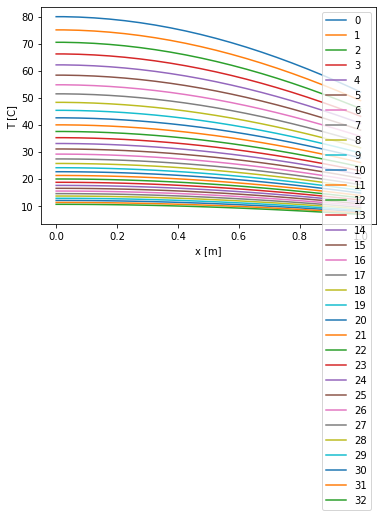

In [388]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x [m]")
plt.ylabel("T [C] ")
plt.legend()
plt.show()

## Analytical solution for the final time

In [389]:
#Definition of the variables
t2 = 3.2632

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T_final = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*t2))*np.cos((z*grid.xP[i])/lx))) + To

print (T_final)



[9.9996306  9.99731791 9.97882282 9.94186686 9.8865184  9.81287983
 9.72108738 9.61131088 9.4837534  9.33865093 9.17627191 8.99691674
 8.80091723 8.58863599 8.36046572 8.11682855 7.8581752  7.5849842
 7.29776093 6.99703677 6.68336806 6.52185993]


### Grid independence analysis

##### For a number of control values of 40

[10.66804431 10.66804431 10.66310951 10.65324219 10.63844691 10.61873053
 10.59410216 10.56457319 10.53015729 10.49087036 10.4467306  10.3977584
 10.34397644 10.28540958 10.22208492 10.15403175 10.08128154 10.00386796
  9.92182682  9.83519605  9.74401575  9.64832807  9.5481773   9.44360975
  9.33467379  9.22141982  9.10390023  8.98216938  8.85628357  8.72630104
  8.59228192  8.4542882   8.31238371  8.1666341   8.01710679  7.86387094
  7.70699743  7.54655884  7.38262938  7.21528488  7.04460275  6.95763235]


#### For a number of control values of 30

[10.66861809 10.66861809 10.6598451  10.64230632 10.61601618 10.58099631
 10.53727549 10.48488967 10.42388195 10.35430248 10.27620848 10.18966418
 10.09474072  9.99151619  9.88007545  9.76051014  9.63291859  9.49740573
  9.35408297  9.20306819  9.04448555  8.87846548  8.70514448  8.52466508
  8.3371757   8.14283052  7.94178933  7.73421747  7.52028563  7.30016972
  7.07405075  6.9580827 ]

#### For a number of control values of 20 this is the profile temperature

[10.67025731 10.67025731 10.65051796 10.61107578 10.55200374 10.4734111
 10.37544328 10.25828149 10.12214248  9.96727811  9.79397486  9.60255333
  9.39336764  9.16680478  8.92328386  8.66325539  8.38720041  8.09562961
  7.78908236  7.46812577  7.13335359  6.95936936]
  
#### For a number of control values of 10:

[10.67910454 10.67910454 10.60014488 10.44280937 10.20826132  9.89823496
  9.51502256  9.06145754  8.54089349  7.95717938  7.31463111  6.96631534]
  
#### For a number of control values of 5:

[10.71441655 10.71441655 10.39854528  9.77611492  8.86547532  7.69347301
  6.99406637]
  


#### From the previous results, without doing the GCI test on this problem, is possible to notice that after the number of control values of 20,  the variance of the results is smaller making the grid independent of the results. The profile temperatures for the last time step was the value of reference to compare between the different number of control volumes, the temperature at x=0 was the one used to compare and its variation.
#### In for this problem, a number of control volumes of 20 will be used to be compared with the other methods.

# First order implicit scheme

## Definition of first order implicit scheme function for calculation

In [390]:
def firstorder (nTime):

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = 20
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    totalT = 3.2632 - 0.4535
    dt = totalT/nTime
    time = 0.4535

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 1

    # Define convection parameters
    ho = 1
    To = 0

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    #Analytical temperature for initial condition

    C1 = 1.1191
    z = 0.8603
    Ti = 100

    T = np.ones(grid.ncv+2)
    for i in range(ncv+2):
        T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

    # Define boundary conditions
    west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
    east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each timestep
    T_solns = [np.copy(T)]
    T_cent = [T[0]]

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

        # Store the solution
        T_solns.append(np.copy(T))
        T_cent.append(T[0])
        
    return (T_solns, T_cent, dt)


## Number of time step  = 2

In [391]:
T_solns2, T_cent2, dt = firstorder(2)

T_exp2 = T_solns2[-1]
dt2 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent2 = np.copy(T_cent2)
print(T_cent2)
deltat2 = np.linspace(0.4535, 3.2632, 3)
print(deltat2)

#To show the solution temperature for verification
print(T_solns2[-1])

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.454633718507182e-15; Avg. Resid. = 9.070001694144736e-16
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 0.014509565669382595; Avg. Resid. = 0.012788745199506669
Iteration = 1; Max. Resid. = 1.1796119636642288e-15; Avg. Resid. = 5.05541788986541e-16
[79.98355299 39.21602633 19.22771853]
[0.4535  1.85835 3.2632 ]
[19.22771853 19.22771853 19.19214835 19.12107379 19.01462633 18.87300291
 18.69646552 18.48534075 18.24001916 17.9609546  17.64866333 17.30372306
 16.92677193 16.51850728 16.07968437 15.61111502 15.11366605 14.58825772
 14.035862   13.45750081 12.85424407 12.54072592]


### Calculation of the error for a time step of 2

In [392]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp2[1:-1]
print(err)
sum_err = np.sum(err)

err_bar2 = np.abs(sum_err)/grid.ncv

print (err_bar2)

[-9.23040062 -9.21332553 -9.17920693 -9.12810794 -9.06012308 -8.97537814
 -8.87402987 -8.75626576 -8.62230367 -8.47239142 -8.30680632 -8.1258547
 -7.92987129 -7.71921865 -7.49428647 -7.25549085 -7.00327352 -6.73810107
 -6.46046404 -6.17087601]
8.135788793453845


## Number of time step of 4

In [393]:
T_solns4, T_cent4, dt = firstorder(4)

T_exp4 = T_solns4[-1]
dt4 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent4 = np.copy(T_cent4)
print(T_cent4)
deltat4 = np.linspace(0.4535, 3.2632, 5)
print(deltat4)

#To show the solution temperature for verification
print(T_solns4[-1])

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.256875242245826e-15; Avg. Resid. = 9.663277122928803e-16
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.01947202567186679; Avg. Resid. = 0.017162606277107164
Iteration = 1; Max. Resid. = 1.9463597400459776e-15; Avg. Resid. = 8.875712664835333e-16
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 0.012812310420059704; Avg. Resid. = 0.011292850828928037
Iteration = 1; Max. Resid. = 1.1093556628871681e-15; Avg. Resid. = 3.93348548177741e-16
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.008430369352808498; Avg. Resid. = 0.007430593772413757
Iteration = 1; Max. Resid. = 9.792514021889076e-16; Avg. Resid. = 2.522938455373769e-16
[79.98355299 52.62827772 34.62890343 22.78549905 14.99264957]
[0.4535   1.155925 1.85835  2.560775 3.2632  ]
[14.99264957 14.99264957 14.9649140

In [394]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp4[1:-1]
print(err)
sum_err = np.sum(err)

err_bar4 = np.abs(sum_err)/grid.ncv

print (err_bar4)

[-4.99533166 -4.98609122 -4.96762745 -4.93997449 -4.90318349 -4.85732252
 -4.80247641 -4.73874661 -4.66625101 -4.58512372 -4.4955148  -4.39759002
 -4.29153052 -4.17753249 -4.0558068  -3.92657862 -3.79008701 -3.64658445
 -3.49633638 -3.33962075]
4.402965521272244


### Number of time step of 8

In [395]:
T_solns8, T_cent8, dt = firstorder(8)

T_exp8 = T_solns8[-1]
dt8 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent8 = np.copy(T_cent8)
print(T_cent8)
deltat8 = np.linspace(0.4535, 3.2632, 9)
print(deltat8)

#To show the solution temperature for verification
print(T_solns8[-1])

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.168404344971009e-15; Avg. Resid. = 1.0678957718113225e-15
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.02348881205739417; Avg. Resid. = 0.02070288202562261
Iteration = 1; Max. Resid. = 2.473715676742927e-15; Avg. Resid. = 1.1016361434190713e-15
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 0.018643361268965465; Avg. Resid. = 0.0164323324860971
Iteration = 1; Max. Resid. = 2.0469737016526324e-15; Avg. Resid. = 9.3119956190435e-16
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.014797574932387649; Avg. Resid. = 0.013042687401363415
Iteration = 1; Max. Resid. = 1.052977149917922e-15; Avg. Resid. = 3.8606270957863844e-16
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 0.011745131898491933; Avg. Resid. = 0.010352252152922115
Iteration = 1; Max. 

In [396]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp8[1:-1]
print(err)
sum_err = np.sum(err)

err_bar8 = np.abs(sum_err)/grid.ncv

print (err_bar8)

[-2.60181724 -2.59700467 -2.58738843 -2.5729863  -2.55382494 -2.52993977
 -2.50137498 -2.46818341 -2.43042645 -2.38817394 -2.34150403 -2.29050305
 -2.23526534 -2.17589306 -2.11249604 -2.04519155 -1.97410407 -1.89936511
 -1.82111289 -1.73949217]
2.293302371239995


### Number of time step of 16

In [397]:
T_solns16, T_cent16, dt = firstorder(16)

T_exp16 = T_solns16[-1]
dt16 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent16 = np.copy(T_cent16)
print(T_cent16)
deltat16 = np.linspace(0.4535, 3.2632, 17)
print(deltat16)

#To show the solution temperature for verification
print(T_solns16[-1])

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 3.0600522116230877e-15; Avg. Resid. = 1.1480399964014509e-15
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.026190218384689955; Avg. Resid. = 0.023083704849656585
Iteration = 1; Max. Resid. = 2.858824288409778e-15; Avg. Resid. = 1.0709315378942819e-15
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 0.023178044993851187; Avg. Resid. = 0.020429103033228636
Iteration = 1; Max. Resid. = 2.159730727591125e-15; Avg. Resid. = 7.647528443843754e-16
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.02051243451226128; Avg. Resid. = 0.018079752454512384
Iteration = 1; Max. Resid. = 3.138114768042044e-15; Avg. Resid. = 8.592952738251114e-16
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 0.018153446075237414; Avg. Resid. = 0.01600057069598427
Iteration = 1; Max. Resid

In [398]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp16[1:-1]
print(err)
sum_err = np.sum(err)

err_bar16 = np.abs(sum_err)/grid.ncv

print (err_bar16)

[-1.32890776 -1.32644999 -1.32153901 -1.31418389 -1.30439824 -1.29220016
 -1.2776122  -1.26066135 -1.24137895 -1.21980066 -1.19596641 -1.16992026
 -1.14171039 -1.11138896 -1.07901207 -1.04463959 -1.00833508 -0.9701657
 -0.93020203 -0.88851799]
1.1713495346385474


### Calculation of the error for a Time step of 32

In [399]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp32[1:-1]
print(err)
sum_err = np.sum(err)

err_bar32 = np.abs(sum_err)/grid.ncv

print (err_bar32)

[-0.67290975 -0.67166554 -0.66917943 -0.66545601 -0.66050217 -0.65432706
 -0.6469421  -0.63836095 -0.62859948 -0.61767573 -0.6056099  -0.5924243
 -0.57814331 -0.56279334 -0.54640277 -0.5290019  -0.51062291 -0.49129978
 -0.47106824 -0.4499657 ]
0.5931475186971409


## Calculation of the value of P

Using the errors calculated for each time step, the value of P is founded with the following procedure. Since the value of p represents the order accuracy of the transient scheme, is expected that this value is close to 1.

[1.40485    0.702425   0.3512125  0.17560625 0.08780312]
[8.13578879 4.40296552 2.29330237 1.17134953 0.59314752]
0.9465942636164619
Value of P is: 0.9465942636164619


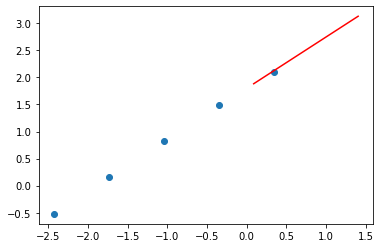

In [400]:
#To generate the plot of e bar vs deltat

from scipy import stats
import numpy as np

x = np.array([dt2, dt4, dt8, dt16, dt32])
print (x)
y = np.array([err_bar2, err_bar4, err_bar8, err_bar16, err_bar32])

print (y)

res = stats.linregress(np.log(x), np.log(y))

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(res.slope)
print ("Value of P is:", res.slope)

plt.plot(np.log(x), np.log(y), 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

### Analysis of the results of the value of P

As expected, the value of P is close to 1, following the order of this scheme. Is possible to notice that the error decreases by the double with the increase of the number of time step as we might expect for this implicit first order scheme method. In this case is possible to notice that for the number of time step of 32 is still high since it is approximate 0.60, if the problem to be solved needs a more accurate result with a small percentage of error, is important to increase the number of time step until obtain the error desired. 

## Plot of the changes of the temperature at x=0 at the different time step

In order to analyze the behaviour of the method, the following plot represents the temperature at the centre of the wall and it change with time for the different number of time step.

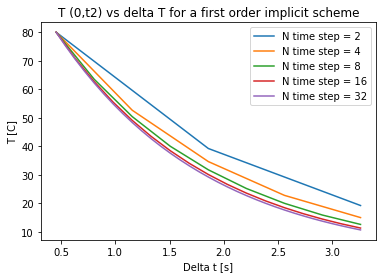

In [401]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(deltat2, T_cent2, label="N time step = 2")
ax.plot(deltat4, T_cent4, label="N time step = 4")
ax.plot(deltat8, T_cent8, label="N time step = 8")
ax.plot(deltat16, T_cent16, label="N time step = 16")
ax.plot(deltat32, T_cent32, label="N time step = 32")


ax.set_title("T (0,t2) vs delta T for a first order implicit scheme")
ax.set_xlabel("Delta t [s]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Analysis

As discussed before with the error, the higher number of time step provide a smoother curve in the results of the temperature disminution along the defined time. The smaller the time step the more accurate result within time since it is a first order scheme.

# Second order implicit scheme

## Definition of the function for the second order implicit scheme 

In [402]:
import math

def secondorder (nTime):
    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = 20
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    totalT = 3.2632 - 0.4535
    dt = totalT/nTime
    time = 0.4535

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 1

    # Define convection parameters
    ho = 1
    To = 0

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    #Analytical temperature for initial condition

    C1 = 1.1191
    z = 0.8603
    Ti = 100

    T = np.ones(grid.ncv+2)
    for i in range(ncv+2):
        T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


    #Define boundary conditions
    west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
    east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each timestep
    T_solns = [np.copy(T)]
    T_cent = [T[0]]


    # Define the transient model
    Told = np.copy(T)
    Told2 = np.copy(Told) 
    transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told2[:] = Told[:]
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = transient.add(coeffs, tStep)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

        # Store the solution
        T_solns.append(np.copy(T))
        T_cent.append(T[0])

    return (T_solns, T_cent, dt)


## Number of time step = 32

In [403]:
T_solns32, T_cent32, dt = secondorder(32)

T_exp32 = T_solns32[-1]
dt32 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent32 = np.copy(T_cent32)
print(T_cent32)
deltat32 = np.linspace(0.4535, 3.2632, 33)
print(deltat32)

#To show the solution temperature for verification
print(T_solns32[-1])


Timestep = 0; Time = 0.541303125
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 5.1833537462186996e-15; Avg. Resid. = 2.075943583701445e-15
Timestep = 1; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.0416823683850511; Avg. Resid. = 0.036737954549625654
Iteration = 1; Max. Resid. = 2.931682674400804e-15; Avg. Resid. = 8.07340305719606e-16
Timestep = 2; Time = 0.716909375
Iteration = 0; Max. Resid. = 0.03937461010541322; Avg. Resid. = 0.03470440335819965
Iteration = 1; Max. Resid. = 3.4833247397614286e-15; Avg. Resid. = 1.0772632785815972e-15
Timestep = 3; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.037002377196742535; Avg. Resid. = 0.0326138957618083
Iteration = 1; Max. Resid. = 2.095545958979983e-15; Avg. Resid. = 7.473188734508085e-16
Timestep = 4; Time = 0.8925156249999999
Iteration = 0; Max. Resid. = 0.034708165130465915; Avg. Resid. = 0.03059197548172854
Iteration = 1; Max. Resid. = 2.10942374678779

### Calculation of the error

In [404]:
err = T_final[1:-1] - T_exp32[1:-1]
print(err)
sum_err = np.sum(err)

err_bar32 = np.abs(sum_err)/grid.ncv

print (err_bar32)

[-0.00632576 -0.00631469 -0.00629258 -0.00625947 -0.0062154  -0.00616046
 -0.00609474 -0.00601836 -0.00593146 -0.00583417 -0.00572668 -0.00560917
 -0.00548184 -0.00534491 -0.00519864 -0.00504326 -0.00487906 -0.00470631
 -0.00452532 -0.0043364 ]
0.005614933751495377


## Number of time step = 2

In [405]:
T_solns2, T_cent2, dt = secondorder(2)

T_exp2 = T_solns2[-1]
dt2 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent2 = np.copy(T_cent2)
print(T_cent2)
deltat2 = np.linspace(0.4535, 3.2632, 3)
print(deltat2)

#To show the solution temperature for verification
print(T_solns2[-1])



Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.454633718507182e-15; Avg. Resid. = 9.070001694144736e-16
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 0.021764348504073303; Avg. Resid. = 0.019183117799260317
Iteration = 1; Max. Resid. = 1.6289053439422219e-15; Avg. Resid. = 5.044792708575052e-16
[79.98355299 39.21602633 15.13665102]
[0.4535  1.85835 3.2632 ]
[15.13665102 15.13665102 15.10864927 15.05269758 14.96889946 14.8574099
 14.71843516 14.55223231 14.35910881 14.1394219  13.89357797 13.6220318
 13.3252857  13.0038886  12.65843503 12.28956401 11.89795791 11.4843411
 11.0494787  10.59417512 10.11927257  9.87246104]


### Calculation of the error

In [406]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp2[1:-1]
print(err)
sum_err = np.sum(err)

err_bar2 = np.abs(sum_err)/grid.ncv

print (err_bar2)

[-5.13933311 -5.12982645 -5.11083072 -5.08238106 -5.04453007 -4.99734777
 -4.94092143 -4.87535541 -4.80077097 -4.71730606 -4.62511506 -4.52436846
 -4.41525261 -4.29796931 -4.17273547 -4.0397827  -3.8993569  -3.75171777
 -3.59713835 -3.43590451]
4.529897209080146


## Number of time step = 4

In [407]:
T_solns4, T_cent4, dt = secondorder(4)

T_exp4 = T_solns4[-1]
dt4 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent4 = np.copy(T_cent4)
print(T_cent4)
deltat4 = np.linspace(0.4535, 3.2632, 5)
print(deltat4)

#To show the solution temperature for verification
print(T_solns4[-1])



Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.256875242245826e-15; Avg. Resid. = 9.663277122928803e-16
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.02920803850780023; Avg. Resid. = 0.02574390941566059
Iteration = 1; Max. Resid. = 2.211772431870429e-15; Avg. Resid. = 5.702903427273753e-16
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 0.019185795255336202; Avg. Resid. = 0.016910545857335476
Iteration = 1; Max. Resid. = 1.1657341758564144e-15; Avg. Resid. = 6.063725910276929e-16
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.011767491536453796; Avg. Resid. = 0.0103719888420952
Iteration = 1; Max. Resid. = 7.233796894823286e-16; Avg. Resid. = 2.824346659324739e-16
[79.98355299 52.62827772 32.31287668 18.96824617 10.78339168]
[0.4535   1.155925 1.85835  2.560775 3.2632  ]
[10.78339168 10.78339168 10.76344305 1

### Calculation of the error

In [408]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp4[1:-1]
print(err)
sum_err = np.sum(err)

err_bar4 = np.abs(sum_err)/grid.ncv

print (err_bar4)

[-0.78607378 -0.78462023 -0.78171584 -0.77736596 -0.77157863 -0.76436457
 -0.7557371  -0.74571217 -0.73430833 -0.72154666 -0.70745075 -0.69204667
 -0.6753629  -0.65743029 -0.638282   -0.61795343 -0.59648218 -0.57390794
 -0.55027247 -0.52561946]
0.6928915687083191


## Number of time step = 8

In [409]:
T_solns8, T_cent8, dt = secondorder(8)

T_exp8 = T_solns8[-1]
dt8 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent8 = np.copy(T_cent8)
print(T_cent8)
deltat8 = np.linspace(0.4535, 3.2632, 9)
print(deltat8)

#To show the solution temperature for verification
print(T_solns8[-1])



Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.168404344971009e-15; Avg. Resid. = 1.0678957718113225e-15
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.03523321808609083; Avg. Resid. = 0.03105432303843375
Iteration = 1; Max. Resid. = 2.2863655413374318e-15; Avg. Resid. = 7.10629471933899e-16
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 0.028295493040102954; Avg. Resid. = 0.024939839738089747
Iteration = 1; Max. Resid. = 2.3713669916602953e-15; Avg. Resid. = 7.799316747991725e-16
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.022145981740660254; Avg. Resid. = 0.01951969374229747
Iteration = 1; Max. Resid. = 1.4363510381087963e-15; Avg. Resid. = 6.687358999890591e-16
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 0.01712851907855617; Avg. Resid. = 0.015097236954708187
Iteration = 1; Max.

### Calculation of the error

In [410]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp8[1:-1]
print(err)
sum_err = np.sum(err)

err_bar8 = np.abs(sum_err)/grid.ncv

print (err_bar8)

[-0.07488805 -0.07475015 -0.0744746  -0.07406191 -0.07351284 -0.0728284
 -0.07200986 -0.07105871 -0.06997671 -0.06876585 -0.06742837 -0.06596672
 -0.0643836  -0.06268192 -0.06086482 -0.05893563 -0.05689792 -0.05475544
 -0.05251213 -0.05017212]
0.06604628724564154


## Number of time step = 16

In [411]:
T_solns16, T_cent16, dt = secondorder(16)

T_exp16 = T_solns16[-1]
dt16 = dt

#Store the temperature at x=0 and create the x values for deltat
T_cent16 = np.copy(T_cent16)
print(T_cent16)
deltat16 = np.linspace(0.4535, 3.2632, 17)
print(deltat16)

#To show the solution temperature for verification
print(T_solns16[-1])



Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 3.0600522116230877e-15; Avg. Resid. = 1.1480399964014509e-15
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.039285327577034845; Avg. Resid. = 0.03462555727448495
Iteration = 1; Max. Resid. = 2.0209528495129803e-15; Avg. Resid. = 5.512083844916305e-16
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 0.03510891328111382; Avg. Resid. = 0.03094501749397165
Iteration = 1; Max. Resid. = 1.908195823574488e-15; Avg. Resid. = 9.21398374265081e-16
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.031028692947072226; Avg. Resid. = 0.027348934300647647
Iteration = 1; Max. Resid. = 2.3973878437999474e-15; Avg. Resid. = 1.0482933965327844e-15
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 0.027303370816399736; Avg. Resid. = 0.02406545264580088
Iteration = 1; Max. Resid.

### Calculation of the error

In [412]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp16[1:-1]
print(err)
sum_err = np.sum(err)

err_bar16 = np.abs(sum_err)/grid.ncv

print (err_bar16)

[-0.01473044 -0.01470382 -0.01465064 -0.014571   -0.01446502 -0.01433292
 -0.01417492 -0.01399131 -0.01378242 -0.01354862 -0.01329035 -0.01300807
 -0.01270228 -0.01237355 -0.01202245 -0.01164963 -0.01125577 -0.01084156
 -0.01040776 -0.00995516]
0.013022884319760664


### To calculate the value of P for the second order implicit scheme

[1.40485    0.702425   0.3512125  0.17560625 0.08780312]
[4.52989721 0.69289157 0.06604629 0.01302288 0.00561493]
2.504549587736702
Value of P is: 2.504549587736702


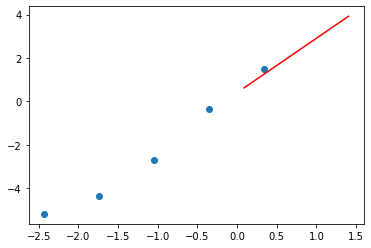

In [413]:
#To generate the plot of e bar vs deltat

from scipy import stats
import numpy as np

x = np.array([dt2, dt4, dt8, dt16, dt32])
print (x)
y = np.array([err_bar2, err_bar4, err_bar8, err_bar16, err_bar32])

print (y)

res = stats.linregress(np.log(x), np.log(y))

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(res.slope)
print ("Value of P is:", res.slope)

plt.plot(np.log(x), np.log(y), 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

### Generation of the temperature profile at the centre of the wall for the diverse number of time step for the final time

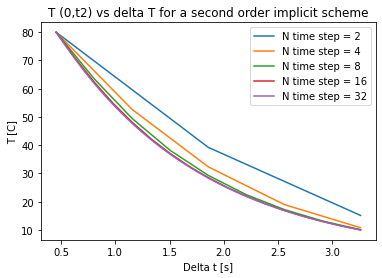

In [414]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()


ax.plot(deltat2, T_cent2, label="N time step = 2")
ax.plot(deltat4, T_cent4, label="N time step = 4")
ax.plot(deltat8, T_cent8, label="N time step = 8")
ax.plot(deltat16, T_cent16, label="N time step = 16")
ax.plot(deltat32, T_cent32, label="N time step = 32")


ax.set_title("T (0,t2) vs delta T for a second order implicit scheme")
ax.set_xlabel("Delta t [s]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Comparison Analysis between first order implicit and second order implicit schemes

- With the first order implicit scheme for the same number of time step of 32 (delta t was 0.08) the error was 0.60 while with the second order implicit scheme this error was approximately 0.006. Is possible to notice that in case that the error needed to be smaller for more accurate result, the second order implicit scheme will provide a better accuracy without compromision the computational cost. While in the case of the first order scheme, in order to increase the accuracy of the method an increase on the number of time step would be necessary which would be translated to an increase on the computational time of the calculation.

- Is expected that the error on the second order scheme is smaller since the order of accuracy obtained for this scheme is expected to be close to 2 which means that the error will decrease when time step increase but in this case for more accurate results to achieve an specific error, the increase of the time step does not need to be as abrupt as it might need to be on a first order scheme. 

- In the temperature profile changes with time, on the first order scheme the difference of the results obtained between the diverse number of time step implemented has a separation gap higher than the second order where the results for the number of time step of 16 and 32 are more close which means a more consistant result.

- Is possible to conclude that the second order scheme will provide a faster convergence to a smaller error of the transient model than the first order. Despite this, is important to generate the time step independence test to corroborate that the results are accurate in the most effective way without compromising the computational time and computational cost of the calculation.